# Thesis work--2
# A new method for multivariate regression problem for improving fitness in Genetic Programming

### Importing the libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randrange, uniform
from sklearn.utils import check_random_state

### Global variables and functions for tuning

In [76]:
FEATURES = 2
NUMBER_OF_GENERATION = 20
ROWS = 300
NUMBER_OF_REGIONS = 3
formula = lambda X: X[:, 0]**2 - X[:, 1]**2 + X[:, 1] - 1

### Generating Training Samples

In [77]:
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)

### Splitting the dataset into the Training set and Test set

In [78]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

### Applying PCA

In [79]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
#print(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
explained_variance = pca.explained_variance_ratio_
#print(X_train_pca)
#print(X_test_pca)
# print(np.shape(X_train),np.shape(X_test))
#print(explained_variance)

### Calculating DV

In [80]:
# sort X_train_pca and y_train by index
sorted_indexes = np.argsort(X_train_pca,axis=0)
sorted_x_train_pca = X_train_pca[sorted_indexes]
sorted_y_train = y_train[sorted_indexes]

# Finding Change of Slope
slope1 = []
slope2 = []
for itr in range(1,len(sorted_x_train_pca)):
    slope1.append((sorted_y_train[itr]-sorted_y_train[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))
for itr in range(1,len(slope1)):
    slope2.append((slope1[itr]-slope1[itr-1])/(sorted_x_train_pca[itr]-sorted_x_train_pca[itr-1]))

# normalize slope2 
normalized_slope2 = (slope2-min(slope2))/(max(slope2)-min(slope2))

# Calculating Quantiles
normalized_slope2 = np.reshape(normalized_slope2,len(normalized_slope2))
quantile_ranges = pd.qcut(normalized_slope2,NUMBER_OF_REGIONS,labels=False,retbins=True)
quantile_ranges = quantile_ranges[1]

# Adding the difficult Vectors
difficult_points = {}
for q_ind in range(NUMBER_OF_REGIONS):
    low = quantile_ranges[q_ind]
    high = quantile_ranges[q_ind+1]
    difficult_points[q_ind] = []
    for n_ind in range(0,len(normalized_slope2)):
        if normalized_slope2[n_ind] >= low and normalized_slope2[n_ind] <= high:
            difficult_points[q_ind].append(n_ind)
print(difficult_points)

{0: [2, 3, 7, 10, 12, 14, 19, 22, 24, 25, 29, 31, 33, 35, 37, 41, 44, 49, 51, 53, 54, 56, 62, 64, 67, 72, 74, 78, 79, 82, 84, 86, 90, 94, 97, 99, 101, 103, 110, 113], 1: [0, 1, 5, 9, 11, 17, 18, 27, 36, 40, 46, 47, 48, 58, 59, 60, 65, 66, 69, 70, 75, 76, 79, 81, 87, 88, 89, 91, 92, 95, 98, 105, 106, 107, 108, 111, 114, 115, 116, 117], 2: [4, 6, 8, 11, 13, 15, 16, 20, 21, 23, 26, 28, 30, 32, 34, 38, 39, 42, 43, 45, 50, 52, 55, 57, 61, 63, 68, 71, 73, 77, 80, 83, 85, 93, 96, 100, 102, 104, 109, 112]}


### Training of converted PCA

In [81]:
from gplearn.genetic import SymbolicRegressor
est_gp = SymbolicRegressor(population_size=200,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)


### Getting the different regions of difficulty level

In [82]:
# Hard to evolve points
hard_to_evolve_x = X_train_pca[difficult_points[0]]
hard_to_evolve_y = y_train[difficult_points[0]]

# Medium to evolve points
medium_to_evolve_x = X_train_pca[difficult_points[1]]
medium_to_evolve_y = y_train[difficult_points[1]]

# Easy to evolve points
easy_to_evolve_x = X_train_pca[difficult_points[2]]
easy_to_evolve_y = y_train[difficult_points[2]]


### Feed the system hard to evolve points first

In [83]:
est_gp.fit(hard_to_evolve_x,hard_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    46.36 103.95173308566565       15 0.5226602104681045 0.18657394344567546      4.37s
   1    11.86 23.322916748615256       33 0.3884718195129449 0.7602442076253353      5.46s
   2    11.55 5.540024311412967       35 0.39116604487612255 0.7285268396738209      4.97s
   3     9.02 1.7667541914578937       11 0.37055460998054696 0.7542954557966416      4.66s
   4     7.01 0.8683875072631347        9 0.3579271037837494 0.753341459143939      4.35s
   5     7.51 0.8936308508199103        9 0.3690778501839116 0.6529847415424794      4.16s
   6     7.03 0.8814993504082793        7 0.369011178876816 0.6078763650522377      3.92s
   7     5.42 0.7360323971326159        5 0.3550027430328087 0.8006980076021338      3.69s
   8     5.47 0.75857284449

### Feed the system Medium to evolve points keeping the current modal state appending generation by current generation

In [84]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*2, warm_start=True)
est_gp.fit(medium_to_evolve_x,medium_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  20      5.4 0.8903543725132039        5 0.3393817360350701 0.7455350791063368      0.25s
  21     5.08 0.7943857101105892        5 0.3416565270180202 0.7250619602597863      0.48s
  22     5.54 0.6894790128054473        5 0.32458809052611953 0.8786778886868923      0.70s
  23     5.57 0.8629974275560174        5 0.3406840738790801 0.6312661117174043      0.84s
  24     5.91 1.000437640319763        5 0.33425546474095513 0.7916715207533717      0.95s
  25     5.46 0.6374379955687229        5 0.3283484783056425 0.8448343986711856      1.02s
  26     5.14 0.7438375907032123        5 0.3356697665269631 0.7789428046793003      1.06s
  27     5.05 0.6642443282170993        5 0.3188566175517007 0.827713218663819      1.06s
  28     5.34 1.39118788767

### Same process but for easy to evolve points and this is our result

In [85]:
est_gp.set_params(generations=NUMBER_OF_GENERATION*3, warm_start=True)
est_gp.fit(easy_to_evolve_x,easy_to_evolve_y)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
  40     5.05 0.7225369142325638        5 0.41481548031694193 0.9397840236417476      0.18s
  41     4.86 0.798482772282206        5 0.4120304407060219 0.9648493801400273      0.29s
  42     5.29 1.4473423551602473        5 0.417675859943919 0.9140406069989542      0.42s
  43     4.85 0.8995415782111235        5 0.41958015843496965 0.8969019205794977      0.48s
  44     5.14 0.9849580389314643        5 0.4260040859823168 0.8390865726533734      0.52s
  45     3.84 0.8126980226047249        5 0.39874060087898244 1.0844579385833826      0.55s
  46     4.47 0.7722303318209905        5 0.40226990838292437 1.0526941710479052      0.58s
  47     4.32 0.7457366675863559        5 0.40233619357999334 1.0520976042742842      0.58s
  48     4.27 0.81291747

### TODO check the results accuracy and compare this method with Standard GP make graphs for visualization

### Training of data without PCA without DV

In [112]:
# Generating random data
rng = check_random_state(0)
X = rng.uniform(-1, 1, ROWS).reshape(ROWS//FEATURES, FEATURES)
Y = formula(X)
# Dividing it into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
# Training the system
est_gp = SymbolicRegressor(population_size=5000,
                           generations=NUMBER_OF_GENERATION, stopping_criteria=0.01,
                           p_crossover=0.7, p_subtree_mutation=0.1,
                           p_hoist_mutation=0.05, p_point_mutation=0.1,
                           max_samples=0.9, verbose=1,
                           parsimony_coefficient=0.01, random_state=0)
est_gp.fit(X_train,y_train)
print(est_gp._program)

    |    Population Average   |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    38.13 14526523.852232037        7 0.34345228187672205 0.39183358697468723      1.33m
   1     9.69 2.2231893389065696        5 0.33069429035251297 0.5045459649453637      1.94m
   2     7.56 7.766714728861279       11 0.2616019900542889 0.23186375873633394      1.90m
   3     5.16 1.9396369188353464       11 0.24135048493135755 0.23860510524886103      1.74m
   4     4.22 1.1487231745028432       11 0.2324422917308899 0.31877884405306967      1.59m
   5     5.72 2.1585597689821436       11 0.04361256297008964 0.04361256297008964      1.53m
   6     7.41 1.3965752246192595       11 0.02358750255327835 0.023587502553278333      1.59m
   7     8.09 2.4486306816297625       11 0.023587502553278343 0.02358750255327836      1.59m
   8     9.41

### Visualize results without converting data to single dimension

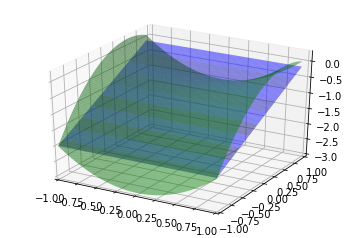

In [101]:
# Generate Data
new_rows = 200
rng = check_random_state(0)
x0 = np.arange(-1,1,.01)
x1 = np.arange(-1,1,0.1)
x0,x1 = np.meshgrid(x0,x1)
y_truth = x0**2 - x1**2 + x1 - 1
fig = plt.figure()
ax=fig.gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
y_pred_truth = (x1 - 0.990)
new_surf = ax.plot_surface(x0, x1, y_pred_truth, rstride=1, cstride=1,
                       color='blue', alpha=0.5)
plt.show()

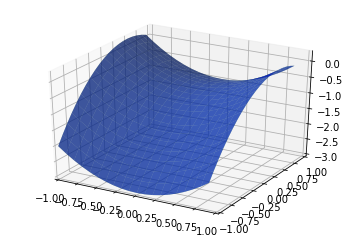

In [113]:
x0 = np.arange(-1, 1, 1/10.)
x1 = np.arange(-1, 1, 1/10.)
x0, x1 = np.meshgrid(x0, x1)
y_truth = x0**2 - x1**2 + x1 - 1

ax = plt.figure().gca(projection='3d')
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
surf = ax.plot_surface(x0, x1, y_truth, rstride=1, cstride=1,
                       color='green', alpha=0.5)
y_pred_truth = ((x0*x0)-(((x1/x1)-x1)+(x1*x1)))
new_surf = ax.plot_surface(x0, x1, y_pred_truth, rstride=1, cstride=1,
                       color='blue', alpha=0.5)
plt.show()

In [89]:
# This result produce doesn't look correct even with Standard GP when the population size = 200 
# and the generation size = 60
# but when the population size = 5000 and the generation size = 20 it produces almost perfect results

### Training of data with PCA without DV

In [88]:
# The problem formula is in 2 dimension so I will get 3d graph of y_truth value if I convert my data values
# into single dimension and than plot it. It should be a line graph. So I should make a line graph on a plane?

### Training of data with PCA with DV

In [90]:
# Same situation as mentioned above the truth value or the actual graph is at least 3 dimensional over here
# But the results I get are in single dimension how can a single dimension be plotted over a multi dimension 

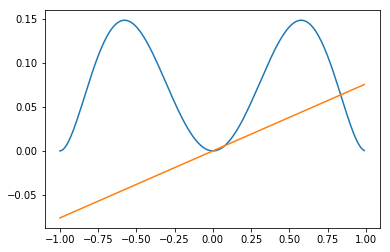

In [67]:
plottingX = np.arange(-1,1,.01)
plottingY = new_formula(plottingX)
updated_formula = lambda X: X*.076
plottingUpdatedY = updated_formula(plottingX)
plt.plot(plottingX,plottingY)
plt.plot(plottingX,plottingUpdatedY)
plt.show()

In [91]:
# The above cell shows results of a single dimension mentioned in paper just to check and it looks like it's producing
# wrong results over here too not sure what I may be doing wrong during training